# Is Electricity More Expensive in Countries with Higher Reliance on Renewables?

By Will Geary ([@wgeary](https://twitter.com/wgeary))

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import pymannkendall as mk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pycountry
import pycountry_convert as pc

# Electricity Prices

Electricity price by country for the year 2019. Units in US$ per kWh.

Source: [World Bank](https://govdata360.worldbank.org/indicators/h6779690b?country=BRA&indicator=42573)

In [2]:
def get_electricity_prices():
    df = pd.read_csv("data/electricity-price.csv")
    indicator = 42573
    df = df[df['Indicator Id'] == indicator]
    df = df[['Country ISO3', 'Country Name', '2019']].reset_index(drop=True)
    df = df.dropna()
    df = df.rename(columns={'Country ISO3': 'Code'})
    df['electricity_price'] = df['2019'] / 100.0 # convert cents to dollars
    del df['2019']
    return df

In [3]:
df = get_electricity_prices()

In [4]:
df.head()

,Code,Country Name,electricity_price
0,AFG,Afghanistan,0.180
1,AGO,Angola,0.037
2,ALB,Albania,0.094
3,ARE,United Arab Emirates,0.109
4,ARG,Argentina,0.108


# Electricity Mix

Electricity mix by country for the year 2019.

Source: [Our World in Data](https://ourworldindata.org/electricity-mix)

In [5]:
def add_electricity_mix(df, year=2019):
    wind = pd.read_csv("data/share-electricity-wind.csv").query(f"Year == {year}")[['Code', 'Wind (% electricity)']]
    solar = pd.read_csv("data/share-electricity-solar.csv").query(f"Year == {year}")[['Code', 'Solar (% electricity)']]
    coal = pd.read_csv("data/share-electricity-coal.csv").query(f"Year == {year}")[['Code', 'Coal (% electricity)']]
    gas = pd.read_csv("data/share-electricity-gas.csv").query(f"Year == {year}")[['Code', 'Gas (% electricity)']]
    hydro = pd.read_csv("data/share-electricity-hydro.csv").query(f"Year == {year}")[['Code', 'Hydro (% electricity)']]
    nuclear = pd.read_csv("data/share-electricity-nuclear.csv").query(f"Year == {year}")[['Code', 'Nuclear (% electricity)']]
    df = pd.merge(df, wind, how='left', on='Code')
    df = pd.merge(df, solar, how='left', on='Code')
    df = pd.merge(df, coal, how='left', on='Code')
    df = pd.merge(df, gas, how='left', on='Code')
    df = pd.merge(df, hydro, how='left', on='Code')
    df = pd.merge(df, nuclear, how='left', on='Code')
    df.columns = [i.replace(" (% electricity)","") for i in df.columns]
    return df

In [6]:
df = add_electricity_mix(df)

In [7]:
df.head()

,Code,Country Name,electricity_price,Wind,Solar,Coal,Gas,Hydro,Nuclear
0,AFG,Afghanistan,0.180,0.000000,4.672897,0.000000,0.000000,78.504670,0.000000
1,AGO,Angola,0.037,0.000000,0.129870,0.000000,23.246754,70.584420,0.000000
2,ALB,Albania,0.094,0.000000,0.384615,0.000000,0.000000,99.615390,0.000000
3,ARE,United Arab Emirates,0.109,0.000000,2.923255,0.000000,97.069040,0.000000,0.000000
4,ARG,Argentina,0.108,3.717332,0.593271,0.826074,64.749170,20.524181,5.985281


# GDP per Capita

GDP per capita, 2019. This data is adjusted for inflation and for differences in the cost of living between countries.

Source: [Our World in Data](https://ourworldindata.org/grapher/gdp-per-capita-worldbank?time=2019)

In [8]:
def add_gdp(df, year=2019):
    gdp = pd.read_csv("data/gdp-per-capita-worldbank.csv").query(f"Year == {year}")[['Code', 'GDP per capita, PPP (constant 2017 international $)']]
    gdp = gdp.rename(columns={'GDP per capita, PPP (constant 2017 international $)': 'gdp_per_capita'})
    df = pd.merge(df, gdp, how='left', on='Code')
    return df

In [9]:
df = add_gdp(df)

In [10]:
df.head()

,Code,Country Name,electricity_price,Wind,Solar,Coal,Gas,Hydro,Nuclear,gdp_per_capita
0,AFG,Afghanistan,0.180,0.000000,4.672897,0.000000,0.000000,78.504670,0.000000,2065.036133
1,AGO,Angola,0.037,0.000000,0.129870,0.000000,23.246754,70.584420,0.000000,6670.331543
2,ALB,Albania,0.094,0.000000,0.384615,0.000000,0.000000,99.615390,0.000000,13656.592773
3,ARE,United Arab Emirates,0.109,0.000000,2.923255,0.000000,97.069040,0.000000,0.000000,68263.671875
4,ARG,Argentina,0.108,3.717332,0.593271,0.826074,64.749170,20.524181,5.985281,22066.101562


# Energy Intensity

Energy intensity represents energy consumption per unit of GDP. It's measured in kilowatt-hours per international $.

Source: [Our World in Data](https://ourworldindata.org/grapher/energy-intensity-vs-gdp)

In [11]:
def add_energy_intensity(df, year=2018):
    intensity = pd.read_csv("data/energy-intensity-vs-gdp.csv").query(f"Year == {year}")
    intensity = intensity.rename(columns={'Primary energy consumption per GDP (kWh/$)': 'energy_intensity'})[['Code', 'energy_intensity']]
    df = pd.merge(df, intensity, how='left', on='Code')
    return df

In [12]:
df = add_energy_intensity(df)

In [13]:
df = df.dropna().reset_index(drop=True)

In [14]:
df.head()

,Code,Country Name,electricity_price,Wind,Solar,Coal,Gas,Hydro,Nuclear,gdp_per_capita,energy_intensity
0,AFG,Afghanistan,0.180,0.000000,4.672897,0.000000,0.000000,78.504670,0.000000,2065.036133,0.621188
1,AGO,Angola,0.037,0.000000,0.129870,0.000000,23.246754,70.584420,0.000000,6670.331543,0.562640
2,ALB,Albania,0.094,0.000000,0.384615,0.000000,0.000000,99.615390,0.000000,13656.592773,1.225269
3,ARE,United Arab Emirates,0.109,0.000000,2.923255,0.000000,97.069040,0.000000,0.000000,68263.671875,1.730462
4,ARG,Argentina,0.108,3.717332,0.593271,0.826074,64.749170,20.524181,5.985281,22066.101562,1.185813


# Governance Indicators

Source: [World Bank](https://databank.worldbank.org/source/worldwide-governance-indicators#)

In [15]:
def add_governance_indicators(df):
    governance_indicators = pd.read_csv("data/governance-indicators.csv").dropna(subset=['Country Code'])
    cols = ['Country Code', '2019 [YR2019]']
    corruption = governance_indicators[governance_indicators['Series Name'] == 'Control of Corruption: Percentile Rank'][cols].rename(columns={'2019 [YR2019]': 'corruption', 'Country Code': 'Code'})
    stability = governance_indicators[governance_indicators['Series Name'] == 'Political Stability and Absence of Violence/Terrorism: Percentile Rank'][cols].rename(columns={'2019 [YR2019]': 'stability', 'Country Code': 'Code'})
    regulatory = governance_indicators[governance_indicators['Series Name'] == 'Regulatory Quality: Percentile Rank'][cols].rename(columns={'2019 [YR2019]': 'regulatory', 'Country Code': 'Code'})
    df = pd.merge(df, corruption, how='left', on='Code')
    df = pd.merge(df, stability, how='left', on='Code')
    df = pd.merge(df, regulatory, how='left', on='Code')
    df['corruption'] = df['corruption'].astype(float)
    df['stability'] = df['stability'].astype(float)
    df['regulatory'] = df['regulatory'].astype(float)
    return df

In [16]:
df = add_governance_indicators(df)

In [17]:
df.head()

,Code,Country Name,electricity_price,Wind,Solar,Coal,Gas,Hydro,Nuclear,gdp_per_capita,energy_intensity,corruption,stability,regulatory
0,AFG,Afghanistan,0.180,0.000000,4.672897,0.000000,0.000000,78.504670,0.000000,2065.036133,0.621188,6.250000,0.943396,10.096154
1,AGO,Angola,0.037,0.000000,0.129870,0.000000,23.246754,70.584420,0.000000,6670.331543,0.562640,12.980769,32.075470,18.750000
2,ALB,Albania,0.094,0.000000,0.384615,0.000000,0.000000,99.615390,0.000000,13656.592773,1.225269,31.730770,51.886791,63.461540
3,ARE,United Arab Emirates,0.109,0.000000,2.923255,0.000000,97.069040,0.000000,0.000000,68263.671875,1.730462,82.692307,69.339622,78.365387
4,ARG,Argentina,0.108,3.717332,0.593271,0.826074,64.749170,20.524181,5.985281,22066.101562,1.185813,54.326923,43.867924,36.057693


# Continent

Associate each country with the continent that contains it.

In [18]:
df['Code_2'] = df['Code'].apply(lambda x: pycountry.countries.get(alpha_3=x).alpha_2)
df['Continent'] = df['Code_2'].apply(lambda x: pc.country_alpha2_to_continent_code(x))
continents = {'AS': 'Asia', 'AF': 'Africa', 'EU': 'Europe', 'SA':'South America', 'OC': 'Oceania', 'NA': 'North America'}
df['Continent'] = df['Continent'].apply(lambda x: continents[x])
del df['Code_2']

In [19]:
df.head()

,Code,Country Name,electricity_price,Wind,Solar,Coal,Gas,Hydro,Nuclear,gdp_per_capita,energy_intensity,corruption,stability,regulatory,Continent
0,AFG,Afghanistan,0.180,0.000000,4.672897,0.000000,0.000000,78.504670,0.000000,2065.036133,0.621188,6.250000,0.943396,10.096154,Asia
1,AGO,Angola,0.037,0.000000,0.129870,0.000000,23.246754,70.584420,0.000000,6670.331543,0.562640,12.980769,32.075470,18.750000,Africa
2,ALB,Albania,0.094,0.000000,0.384615,0.000000,0.000000,99.615390,0.000000,13656.592773,1.225269,31.730770,51.886791,63.461540,Europe
3,ARE,United Arab Emirates,0.109,0.000000,2.923255,0.000000,97.069040,0.000000,0.000000,68263.671875,1.730462,82.692307,69.339622,78.365387,Asia
4,ARG,Argentina,0.108,3.717332,0.593271,0.826074,64.749170,20.524181,5.985281,22066.101562,1.185813,54.326923,43.867924,36.057693,South America


In [20]:
df.shape

(158, 15)

# Exploration

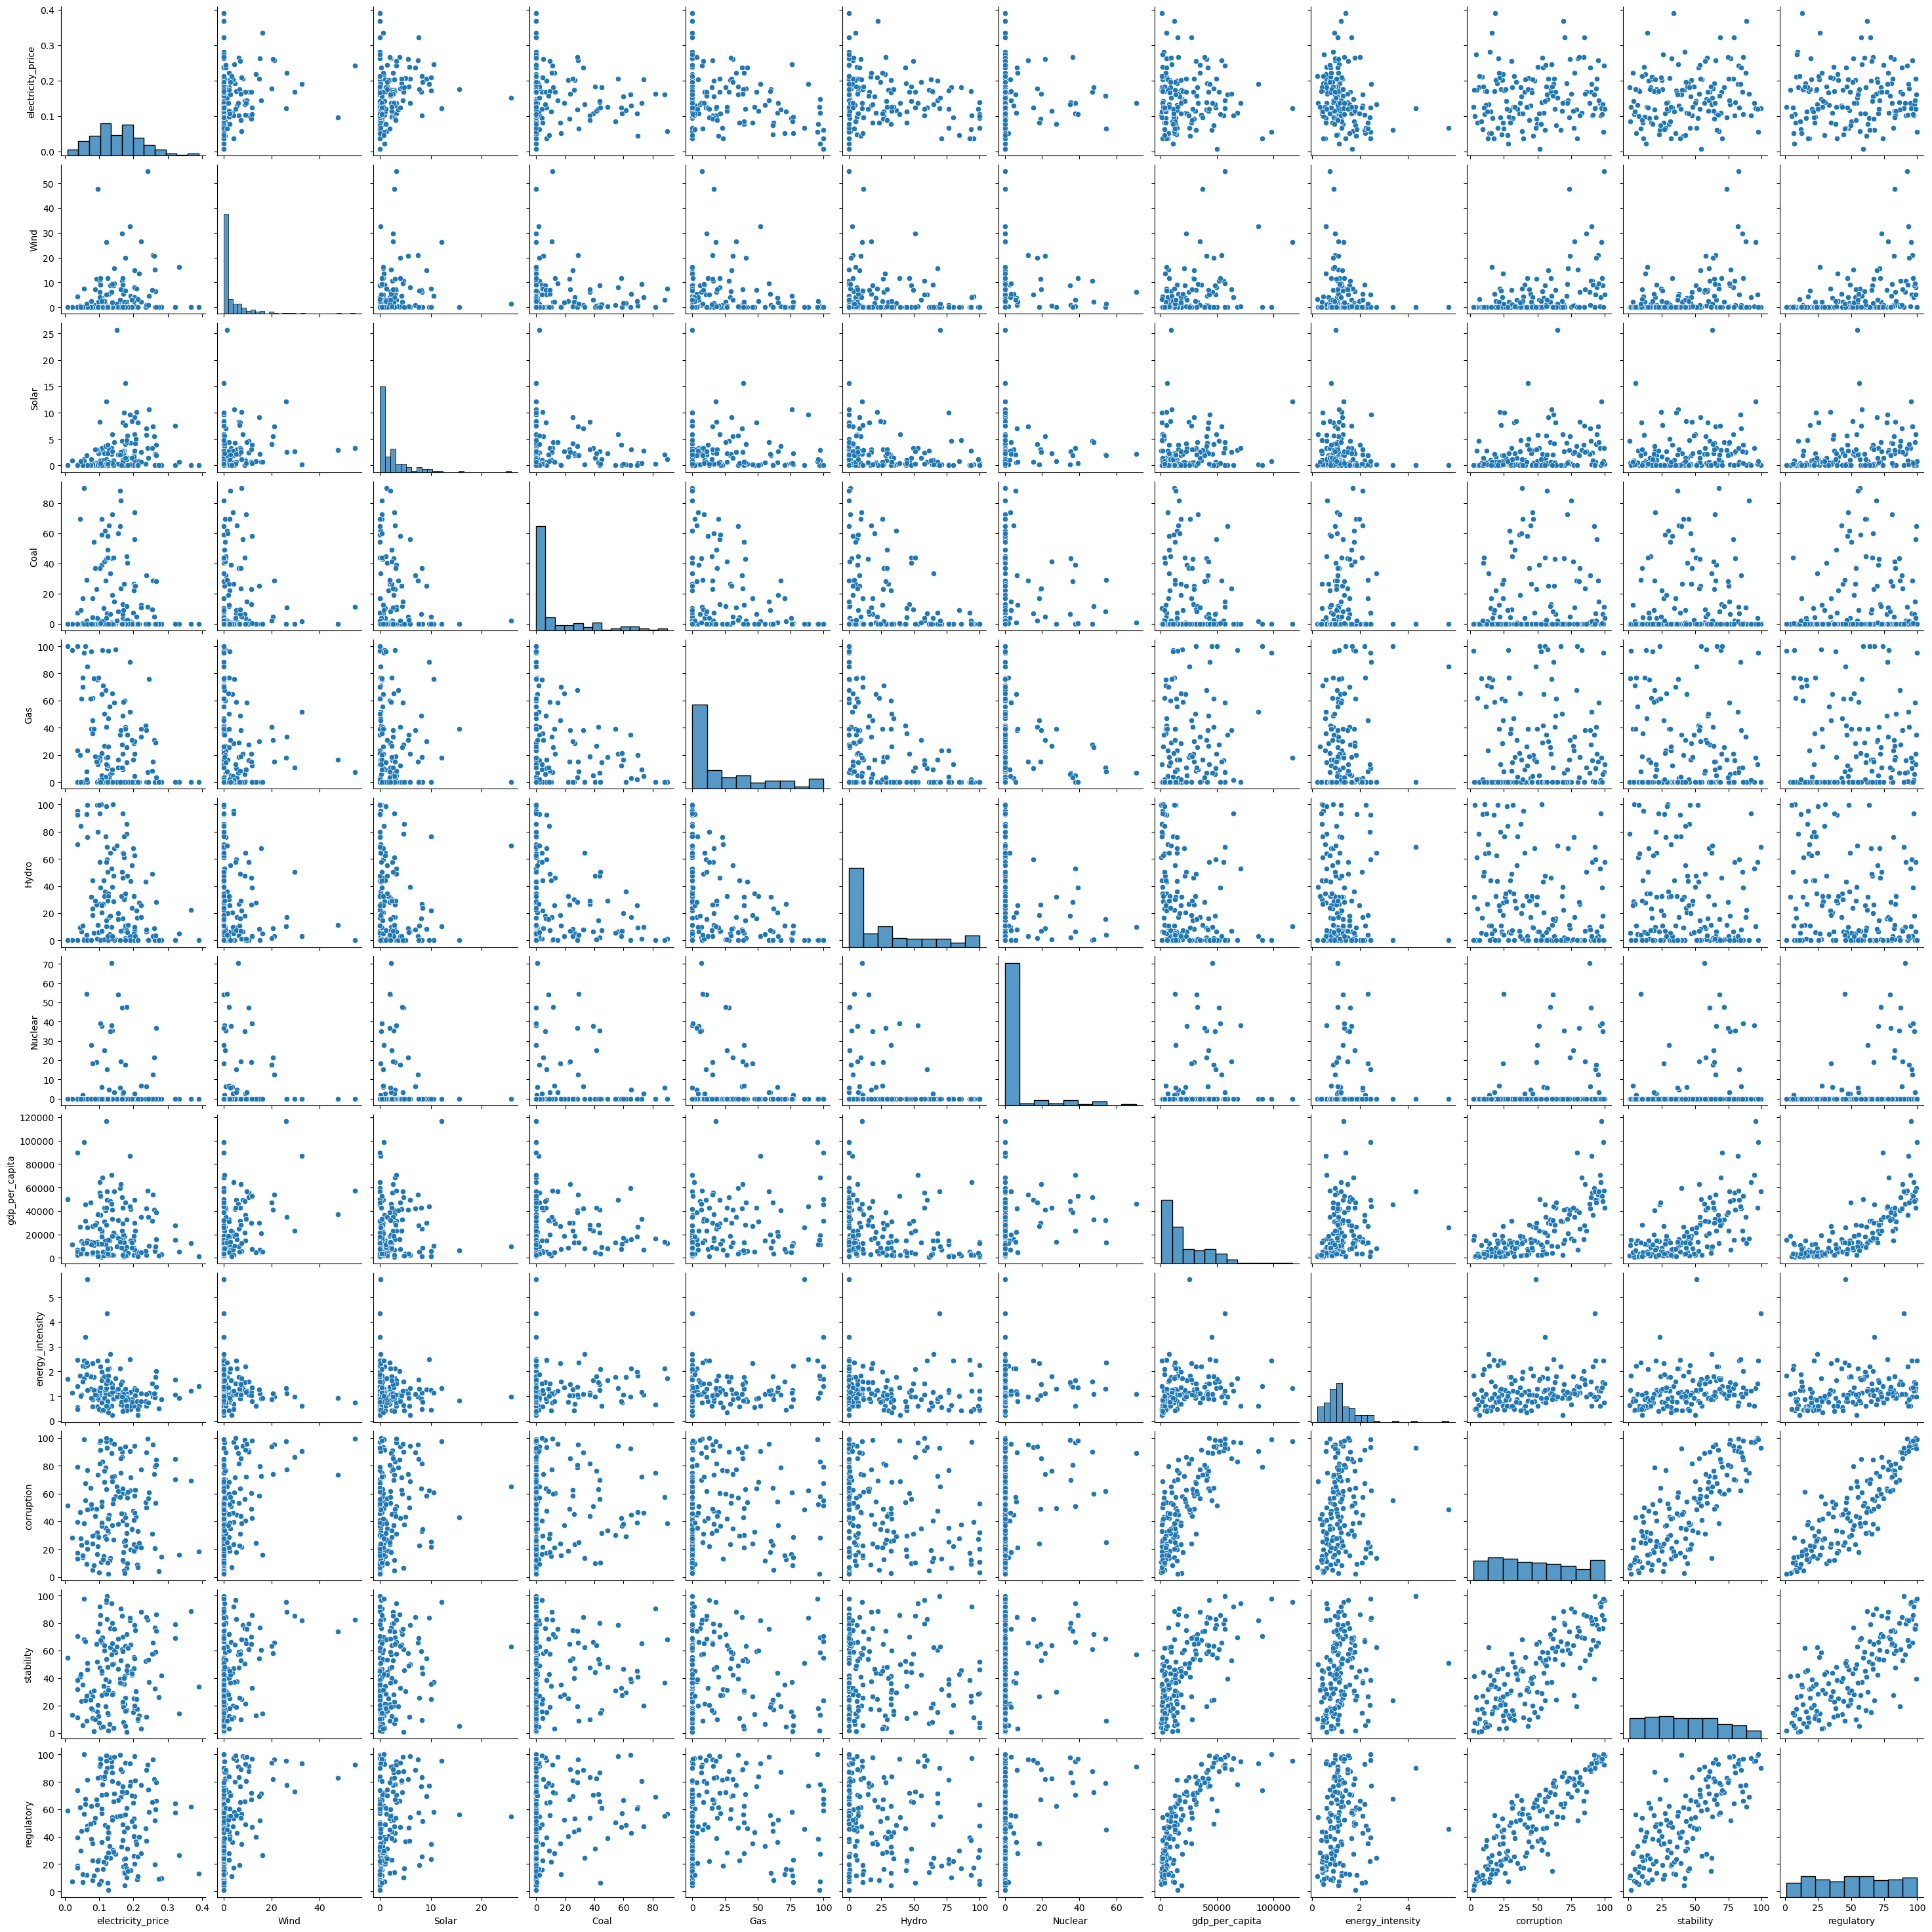

In [21]:
sns.pairplot(data=df);

In [22]:
def calc_price_sensitivity(source, source_range, scenario, formula):
    predicted_price = []
    predicted_price_upper = []
    predicted_price_lower = []

    for i in source_range:
        scenario[source] = i
        remaining = 100 - i
        other_sources = scenario.copy()
        del other_sources[source]
        rescaled = remaining * np.array(list(other_sources.values())) / sum(other_sources.values())
        rescaled_dict = dict(zip(other_sources.keys(), rescaled))
        test_df = pd.DataFrame()
        test_df[source] = [i]
        for k in rescaled_dict:
            test_df[k] = rescaled_dict[k]
        test_df['stability'] = scenario['stability']
        test_df['corruption'] = scenario['corruption']
        test_df['gdp_per_capita'] = scenario['gdp_per_capita']
        test_df['energy_intensity'] = scenario['energy_intensity']
        predictions = model.get_prediction(test_df).summary_frame(alpha=0.05)
        if 'np.log' in model.model.endog_names:
            y_upper = np.exp(predictions['mean_ci_upper'].iloc[0])
            y_hat = np.exp(predictions['mean'].iloc[0])
            y_lower = np.exp(predictions['mean_ci_lower'].iloc[0])
        else:
            y_upper = predictions['mean_ci_upper'].iloc[0]
            y_hat = predictions['mean'].iloc[0]
            y_lower = predictions['mean_ci_lower'].iloc[0]
        predicted_price_upper.append(y_upper)
        predicted_price.append(y_hat)
        predicted_price_lower.append(y_lower)

    results = pd.DataFrame()
    results[source] = source_range
    results['Predicted Price'] = predicted_price
    results['Predicted Price - Upper'] = predicted_price_upper
    results['Predicted Price - Lower'] = predicted_price_lower
    
    trend_test = mk.original_test(predicted_price, alpha=0.001)    
    colors = {'increasing': 'red', 'decreasing': '#1f77b4', 'no trend': 'gray'}
    color = colors[trend_test.trend]

    fig, ax = plt.subplots(figsize=(6,4), dpi=300)
    sns.lineplot(data=results, x=source, y='Predicted Price', color=color, ax=ax)
    ax.fill_between(x=results[source], y1=results['Predicted Price - Upper'],
                    y2=results['Predicted Price - Lower'], alpha=0.2, color=color)
    ax.set_ylabel("Electricty Price ($/kWh)")
    ax.set_xlabel("% of Electricity from " + source)
    ax.set_ylim(0.00, 0.60)
    fmt = '$%.2f'
    tick = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    plt.plot()

# Model

In [23]:
formula = "np.log(electricity_price) ~ np.log(gdp_per_capita) : ( \
                                              np.log(Wind+1) \
                                            + np.log(Solar+1) \
                                            + np.log(Coal+1) \
                                            + np.log(Gas+1) \
                                            + np.log(Hydro+1) \
                                            + np.log(Nuclear+1) \
                                        ) \
                                        + np.log(stability) \
                                        "

model = smf.ols(formula, data=df).fit()

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     np.log(electricity_price)   R-squared:                       0.287
Model:                                   OLS   Adj. R-squared:                  0.254
Method:                        Least Squares   F-statistic:                     8.626
Date:                       Fri, 28 Apr 2023   Prob (F-statistic):           7.12e-09
Time:                               14:49:19   Log-Likelihood:                -107.94
No. Observations:                        158   AIC:                             231.9
Df Residuals:                            150   BIC:                             256.4
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -1.8473      0.187     -9.870      0.000      -2.217      -1.478
np.log(gdp_per_capita):np.log(Wind + 1)        0.0077      0.004      1.876      0.063      -0.000       0.016
np.log(gdp_per_capita):np.log(Solar + 1)       0.0220      0.006      3.778      0.000       0.011       0.034
np.log(gdp_per_capita):np.log(Coal + 1)    -7.069e-05      0.003     -0.027      0.979      -0.005       0.005
np.log(gdp_per_capita):np.log(Gas + 1)        -0.0139      0.002     -5.937      0.000      -0.019      -0.009
np.log(gdp_per_capita):np.log(Hydro + 1)      -0.0059      0.003     -2.073      0.040      -0.012      -0.000
np.log(gdp_per_capita):np.log(Nuclear + 1)     0.0002      0.003      0.069      0.945      -0.006       0.007
np.log(stability)                             -0.0025      0.048     -0.052      0.959      -0.097       0.092
==============================================================================
Omnibus:                       51.514   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.671
Skew:                          -1.273   Prob(JB):                     2.59e-34
Kurtosis:                       7.125   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Price Sensitivity

Let's define a representative scenario on which to model electricity price sensitivity.

In [25]:
scenarios = {
    1: {
        'Wind': 10,
        'Solar': 3,
        'Coal': 20,
        'Gas': 32,
        'Hydro': 20,
        'Nuclear': 15,
        'gdp_per_capita': 50000,
        'corruption': 90,
        'stability': 90,
        'energy_intensity': 1.2
    }
}

In [26]:
scenario = scenarios[1]
source_range = list(range(0,50))

## Solar

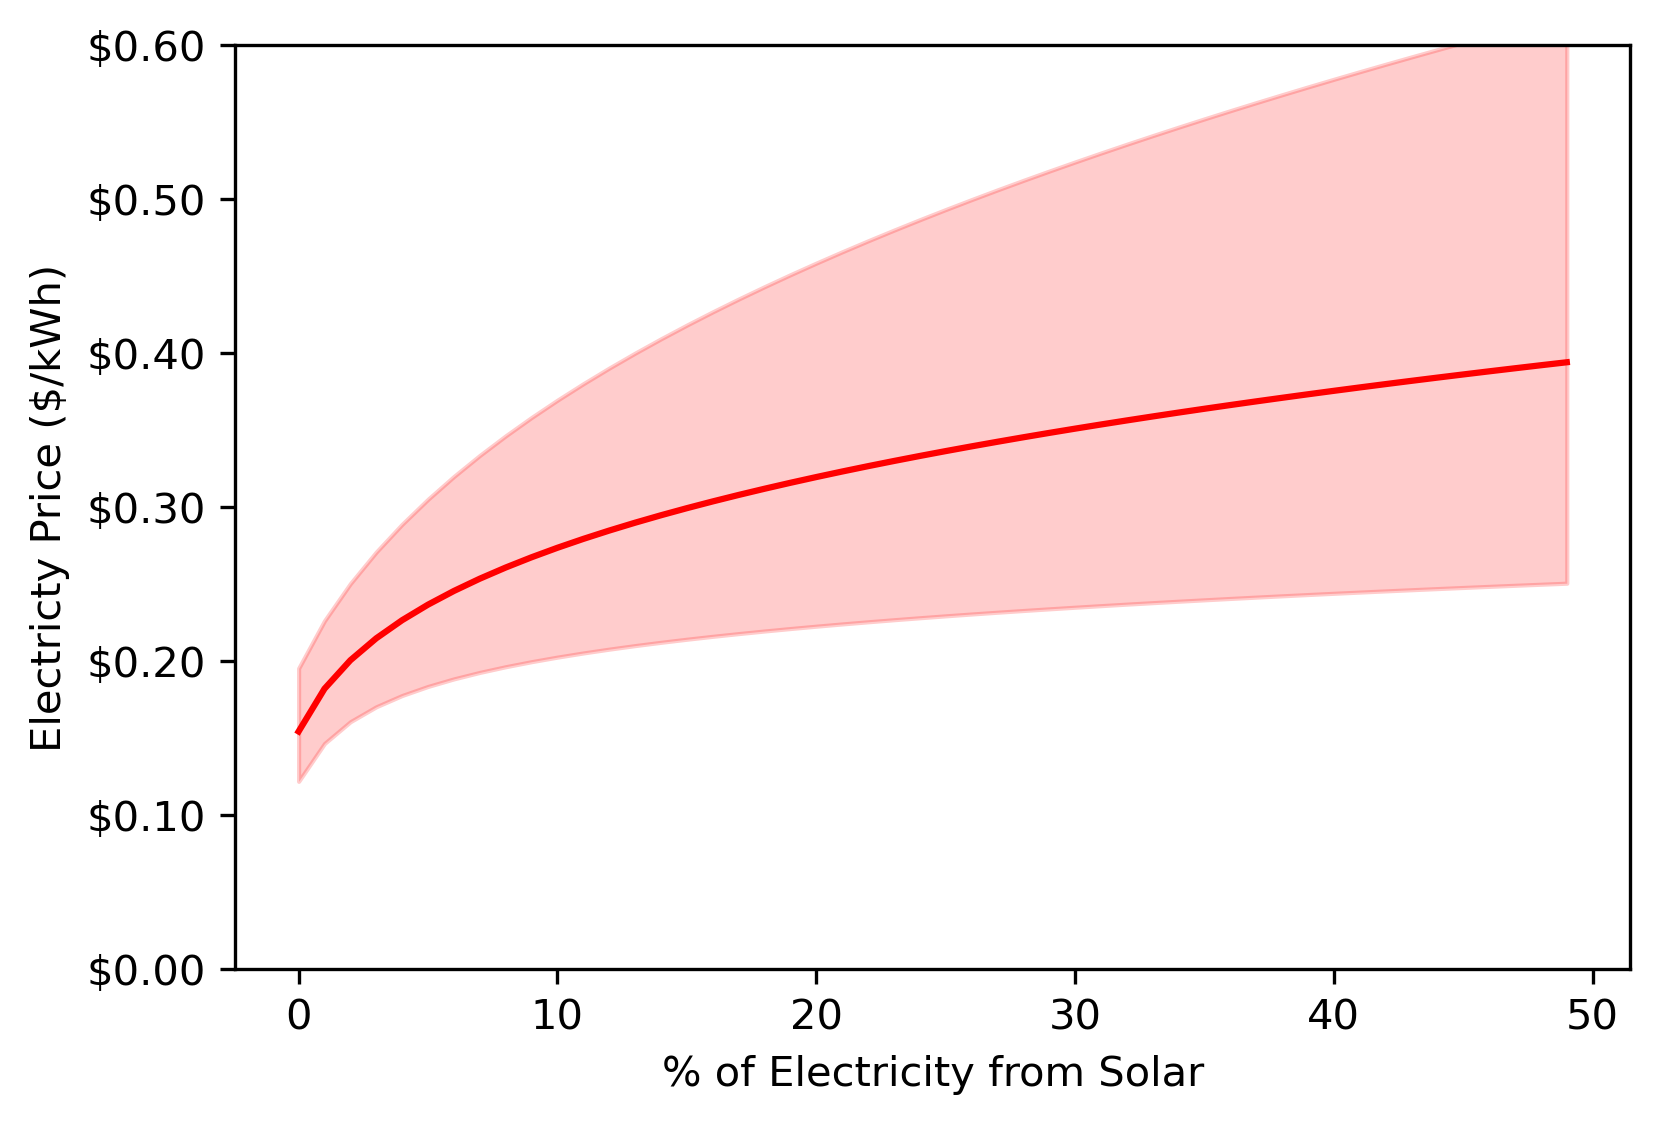

In [27]:
source = 'Solar'
calc_price_sensitivity(source, source_range, scenario, formula)

# Wind

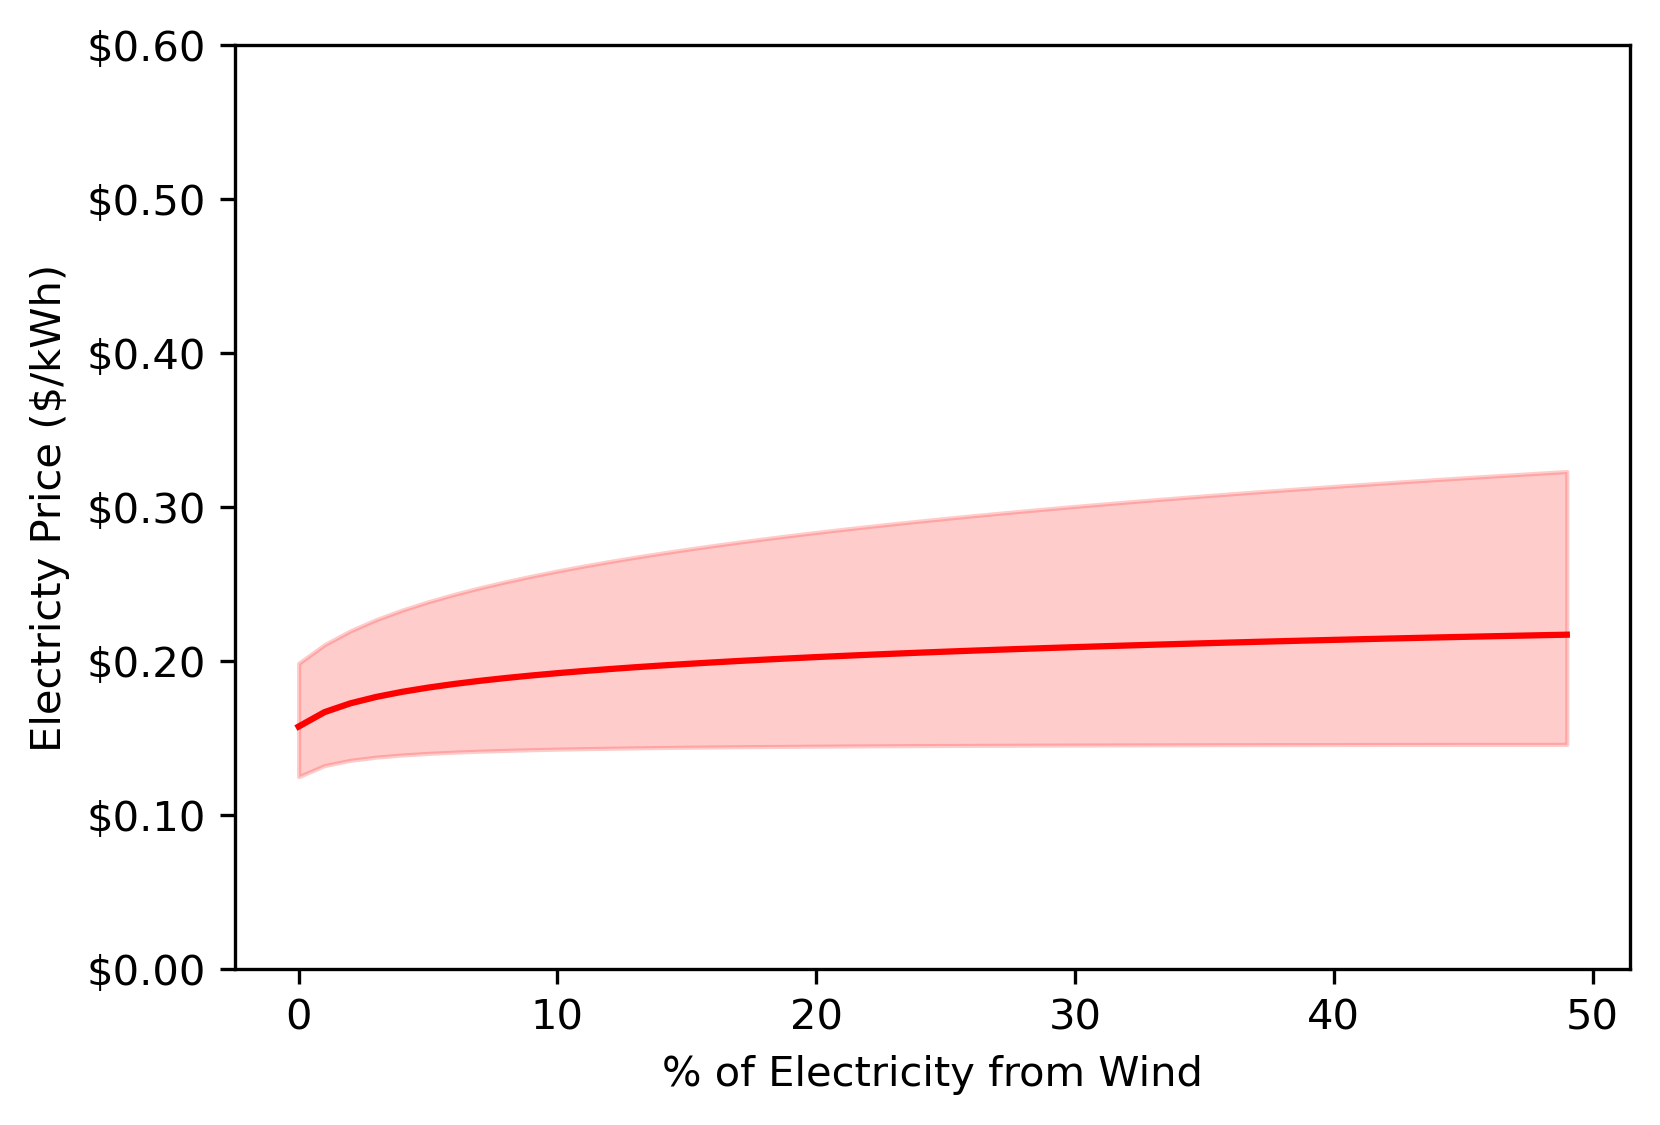

In [28]:
source = 'Wind'
calc_price_sensitivity(source, source_range, scenario, formula)

# Coal

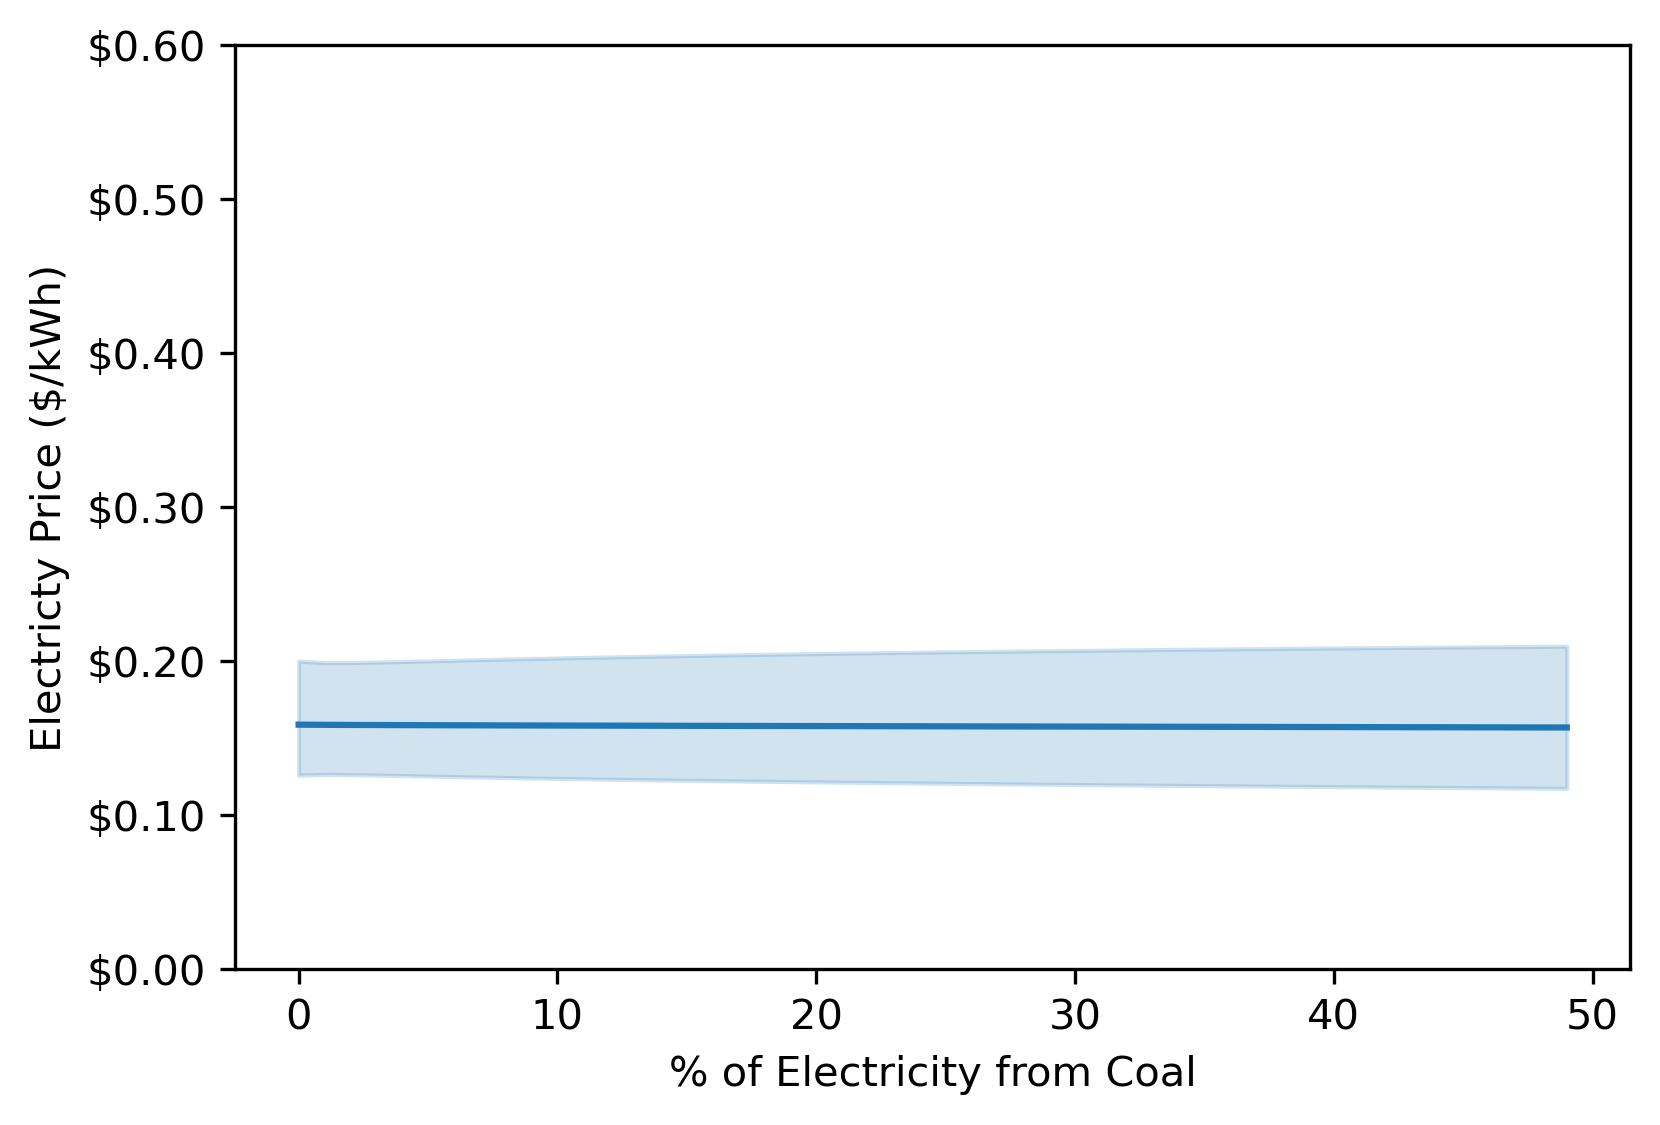

In [29]:
source = 'Coal'
calc_price_sensitivity(source, source_range, scenario, formula)

# Gas

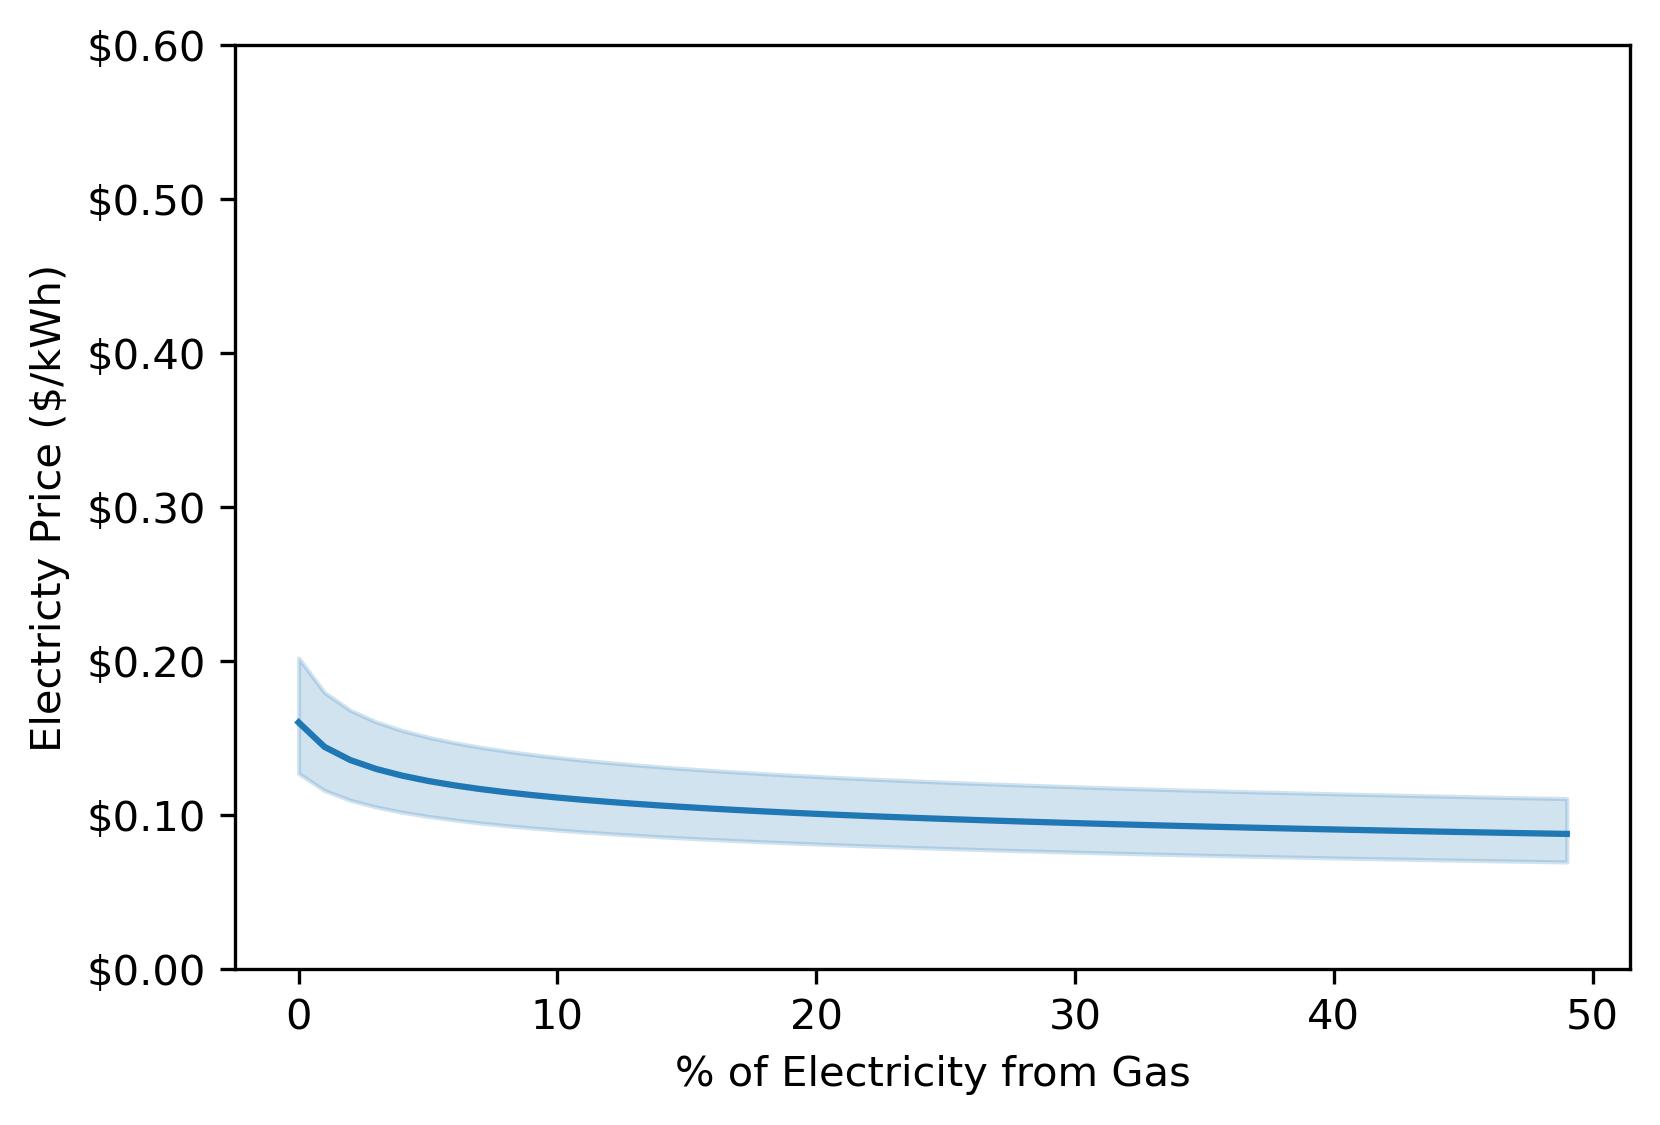

In [30]:
source = 'Gas'
calc_price_sensitivity(source, source_range, scenario, formula)

# Nuclear

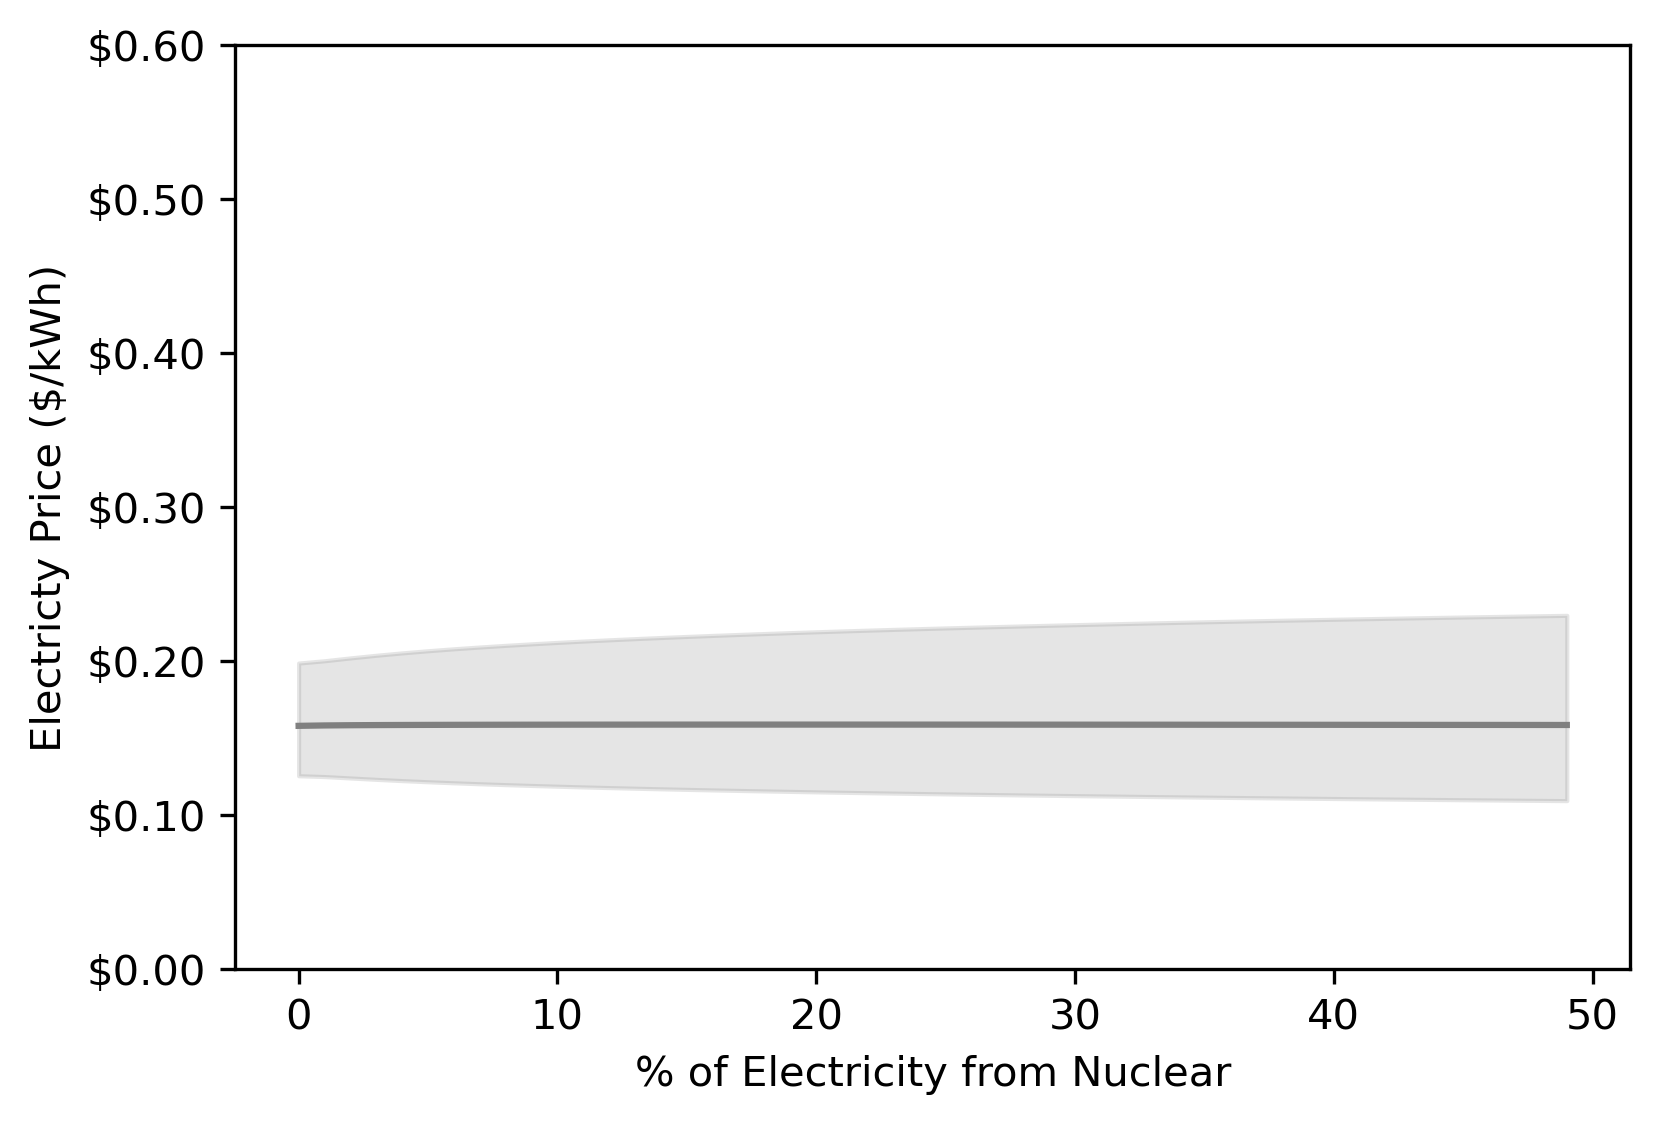

In [31]:
source = 'Nuclear'
calc_price_sensitivity(source, source_range, scenario, formula)

# Hydro

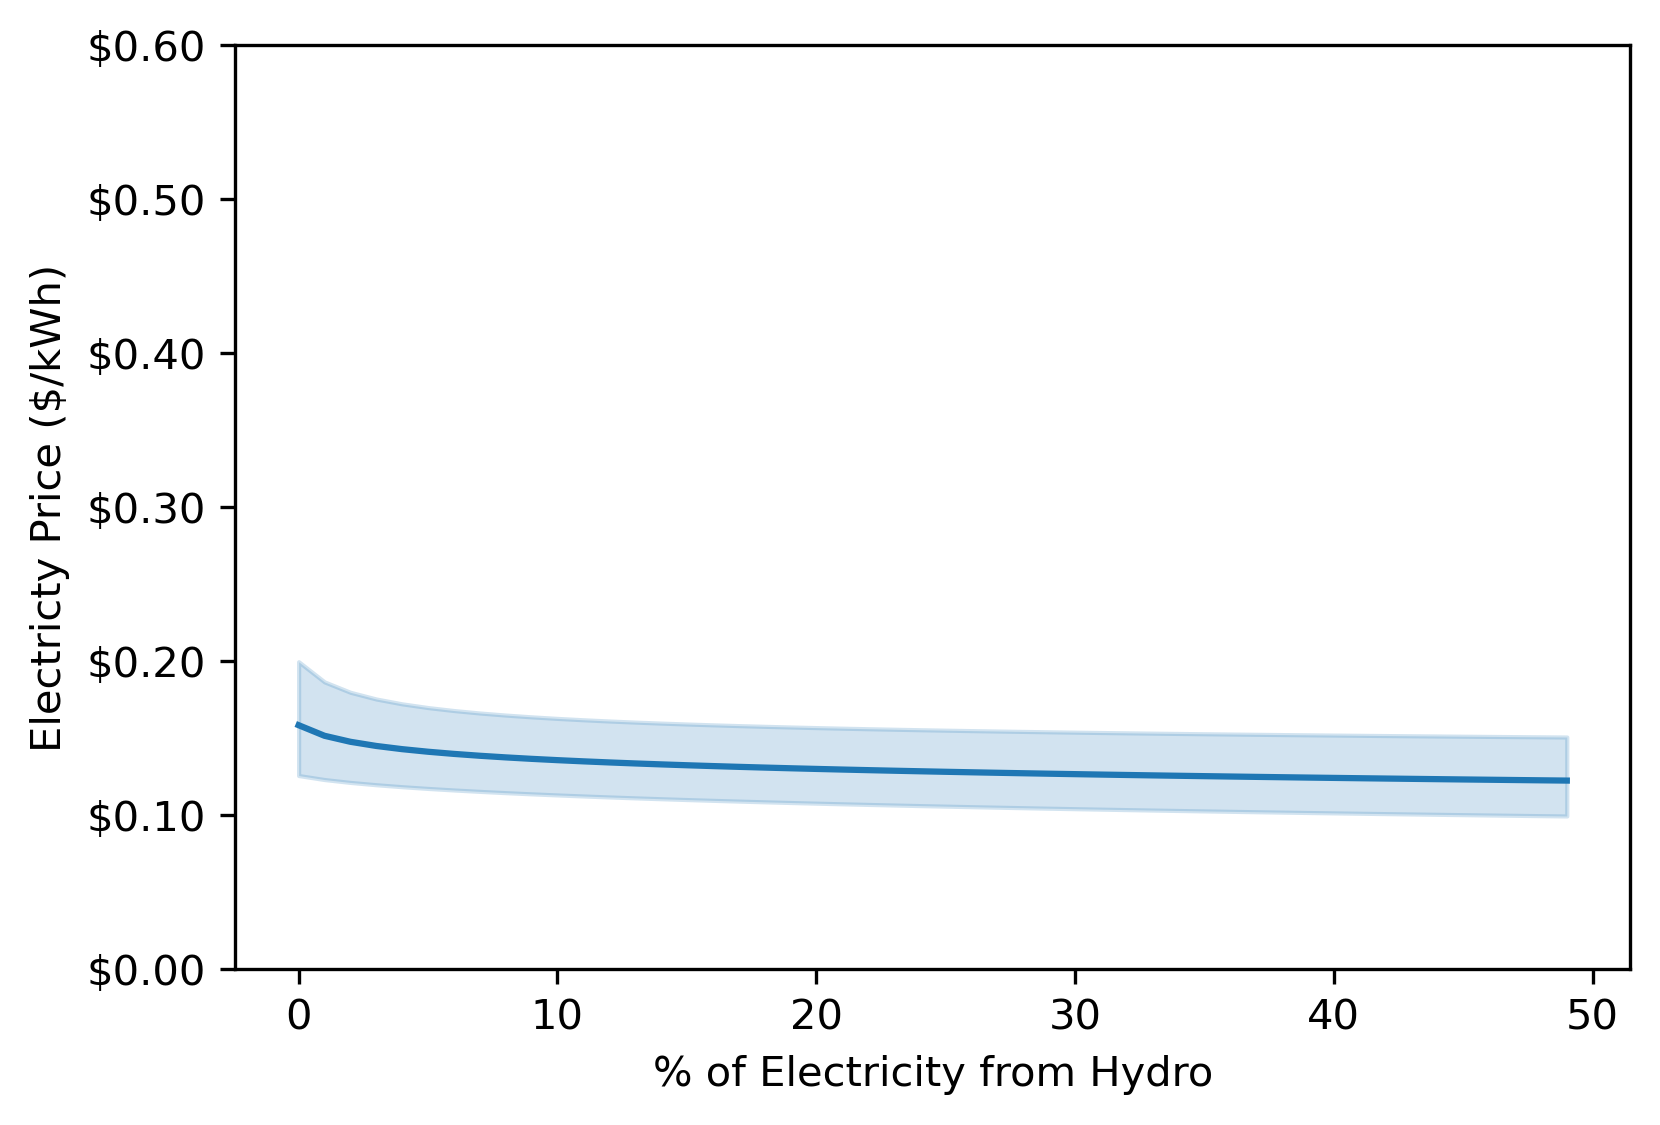

In [32]:
source = 'Hydro'
calc_price_sensitivity(source, source_range, scenario, formula)